In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.dates as mdates
import datetime as dt

In [2]:
# read CSV files and concat into master DataFrame
path = '../Data'
csv_files = glob.glob(path + "/*.csv")
df_list = (pd.read_csv(file) for file in csv_files)
catchment_main = pd.concat(df_list, ignore_index=True)

#### Begin EDA

##### Questions I want to answer:

1. Any data ceilings
2. Size of catchments per state
3. Data issues identified from charts
4. Generally heaviest rainfall months for 3 states + Analysis of rainfall

Report on findings at end and answer these questions

##### Things to identify firstly in the EDA:
- Information about the data set (info, null count, data types, head/tail, samples)
- Rogue values
- Describe
- Box Plot for outliers
- Correlations between features

In [3]:
# Information about the data set (info, null count, data types, head/tail, samples)
catchment_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17488 entries, 0 to 17487
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   State / Territory      17488 non-null  object
 1   Available volume (ML)  17488 non-null  object
 2   Reported date          17488 non-null  object
dtypes: object(3)
memory usage: 410.0+ KB


In [4]:
catchment_main.head(10)

,State / Territory,Available volume (ML),Reported date
0,Australian Capital Territory,"113,854",2018-04-21
1,Australian Capital Territory,"158,430",2021-09-11
2,Australian Capital Territory,"128,455",2018-01-23
3,Australian Capital Territory,"123,636",2018-02-23
4,Australian Capital Territory,"156,079",2016-11-27
5,Australian Capital Territory,"158,430",2022-06-07
6,Australian Capital Territory,"128,808",2017-09-13
7,Australian Capital Territory,"158,430",2021-12-06
8,Australian Capital Territory,"85,585",2019-06-02
9,Australian Capital Territory,"158,430",2021-09-23


In [5]:
catchment_main.tail(10)

,State / Territory,Available volume (ML),Reported date
17478,Western Australia,"4,554,786",2020-02-05
17479,Western Australia,"6,812,221",2019-05-01
17480,Western Australia,"10,704,250",2017-09-26
17481,Western Australia,"3,725,684",2020-09-21
17482,Western Australia,"6,797,469",2017-01-02
17483,Western Australia,"8,444,062",2022-05-01
17484,Western Australia,"5,340,853",2020-03-03
17485,Western Australia,"3,181,525",2020-11-17
17486,Western Australia,"10,797,439",2017-05-23
17487,Western Australia,"8,900,376",2021-04-19


Data looks OK at the top and bottom.

Will get a random sample for a row to check quality.

In [6]:
catchment_main.sample()

,State / Territory,Available volume (ML),Reported date
11479,Tasmania,"12,593,493",2018-07-03


In [7]:
# Issue is data types for Reported date and Available Volume. Should be dates and int.

# Removing commas from Available volume (ML) and converting to int
catchment_main['Available volume (ML)'] = pd.to_numeric(catchment_main['Available volume (ML)'].str.replace(',',''))

# Changing Reported Date to datetime datatype
catchment_main['Reported date'] = pd.to_datetime(catchment_main['Reported date'])

catchment_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17488 entries, 0 to 17487
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   State / Territory      17488 non-null  object        
 1   Available volume (ML)  17488 non-null  int64         
 2   Reported date          17488 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 410.0+ KB


In [8]:
# Checking for nulls
catchment_main.isnull().sum()

State / Territory        0
Available volume (ML)    0
Reported date            0
dtype: int64

### Catchment amount ceilings & Size of catchment per state


I want to see if at any point a state's catchment amount ever hits the max amount (ceiling) of all of the catchments

In [52]:
# Checking what the max amount for each state is.
catchment_max_pivot = catchment_main.pivot_table(index='State / Territory', values='Available volume (ML)', aggfunc='max')
catchment_max_pivot

,Available volume (ML)
State / Territory,
Australian Capital Territory,158430
New South Wales,17949637
Northern Territory,289317
Queensland,8291045
South Australia,2247650
Tasmania,14733687
Victoria,12003173
Western Australia,10946092


On the BOM website, it does list out capacity (ceiling) measurements for each state. I will import that data and compare here.

This also addresses the quesion of **size of catchment per state**.

In [48]:
catchment_ceiling = pd.read_csv('../Data/catchment_capacity.csv')
catchment_ceiling['Accessible Capacity (ML)'] = pd.to_numeric(catchment_ceiling['Accessible Capacity (ML)'].str.replace(',',''))
catchment_ceiling[['State / Territory','Accessible Capacity (ML)']]

,State / Territory,Accessible Capacity (ML)
0,Northern Territory,289317
1,Queensland,10413911
2,Victoria,12591149
3,South Australia,2252391
4,Western Australia,11487072
5,Tasmania,22216631
6,Australian Capital Territory,158430
7,New South Wales,21001139


In [51]:
# Checking if the ceiling data from the BOM website matches the MAX of any of the states we have in our data set. If so, that state would have hit the ceiling at one point in time.
catchment_max_pivot[catchment_max_pivot['Available volume (ML)'].isin(catchment_ceiling['Accessible Capacity (ML)'])]

,Available volume (ML)
State / Territory,
Australian Capital Territory,158430
Northern Territory,289317


We can see that two states in the time period we're reporting on actually reach their maximum holding amount.

In [31]:
# Before plotting date/time data, I will reorder the data to 
# be in date sequencial order.

catchment_main.sort_values(by='Reported date', inplace=True)
catchment_main.head()

,State / Territory,Available volume (ML),Reported date,Month,Year
7891,Queensland,7834870,2016-10-13,10,2016
12362,Tasmania,12331455,2016-10-13,10,2016
13969,Victoria,9716932,2016-10-13,10,2016
17090,Western Australia,6871431,2016-10-13,10,2016
5493,Northern Territory,220827,2016-10-13,10,2016


In [12]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

### Data issues identified from charts

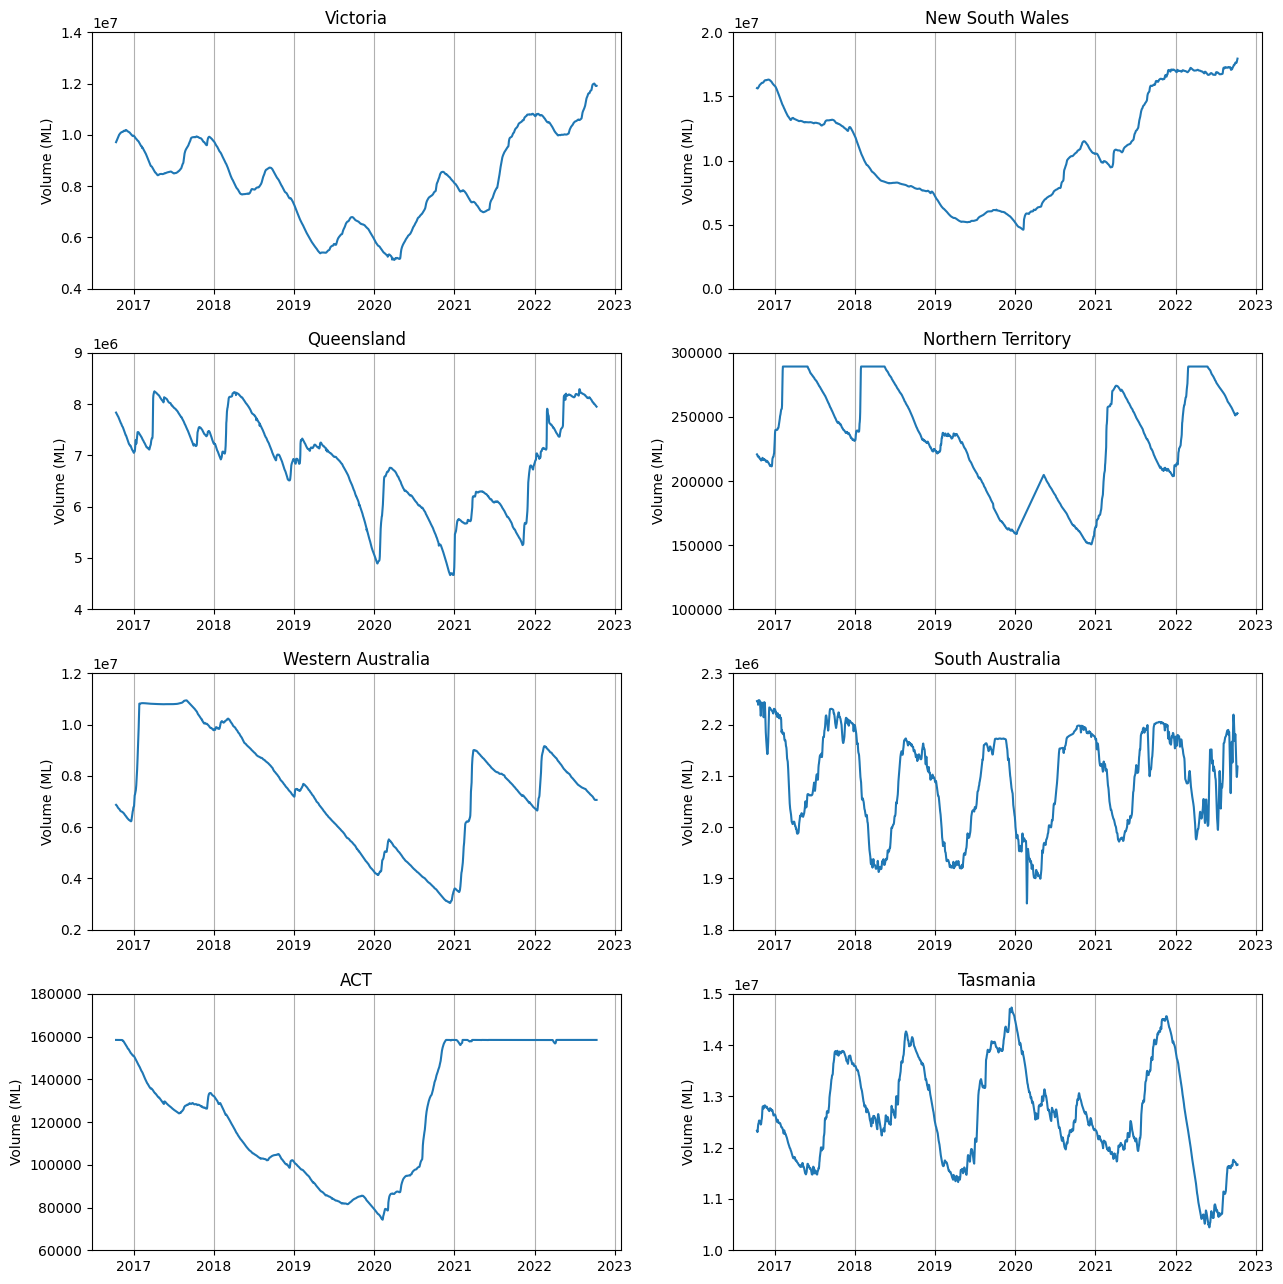

In [53]:
# Firstly, splitting each state into their own dataframe for charting in subplots

vic_data = catchment_main[catchment_main['State / Territory'] == 'Victoria']
nsw_data = catchment_main[catchment_main['State / Territory'] == 'New South Wales']
qld_data = catchment_main[catchment_main['State / Territory'] == 'Queensland']
sa_data = catchment_main[catchment_main['State / Territory'] == 'South Australia']
nt_data = catchment_main[catchment_main['State / Territory'] == 'Northern Territory']
wa_data = catchment_main[catchment_main['State / Territory'] == 'Western Australia']
act_data = catchment_main[catchment_main['State / Territory'] == 'Australian Capital Territory']
tas_data = catchment_main[catchment_main['State / Territory'] == 'Tasmania']
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

plt.figure(figsize=(13,13))

plt.subplot(4,2,1)
plt.plot(vic_data['Reported date'], vic_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('Victoria')
plt.grid(axis='x')

plt.subplot(4,2,2)
plt.plot(nsw_data['Reported date'], nsw_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('New South Wales')
plt.grid(axis='x')

plt.subplot(4,2,3)
plt.plot(qld_data['Reported date'], qld_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('Queensland')
plt.grid(axis='x')

plt.subplot(4,2,4)
plt.plot(nt_data['Reported date'], nt_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('Northern Territory')
plt.grid(axis='x')

plt.subplot(4,2,5)
plt.plot(wa_data['Reported date'], wa_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('Western Australia')
plt.grid(axis='x')

plt.subplot(4,2,6)
plt.plot(sa_data['Reported date'], sa_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('South Australia')
plt.grid(axis='x')

plt.subplot(4,2,7)
plt.plot(act_data['Reported date'], act_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('ACT')
plt.grid(axis='x')

plt.subplot(4,2,8)
plt.plot(tas_data['Reported date'], tas_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('Tasmania')
plt.grid(axis='x')

plt.style.use('classic')

plt.tight_layout()

I want to take a closer look at Northern Territory's data before moving onto the analysis as it looks like there is a portion of time where it is a straight
line that rises, instead of moving organically.

C:\Users\vidmy2k\AppData\Local\Temp\ipykernel_13888\564886498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nt_data_2020['Month'] = pd.DatetimeIndex(nt_data_2020['Reported date']).month


Text(0.5, 1.0, 'Northern Territory - 2020 data')

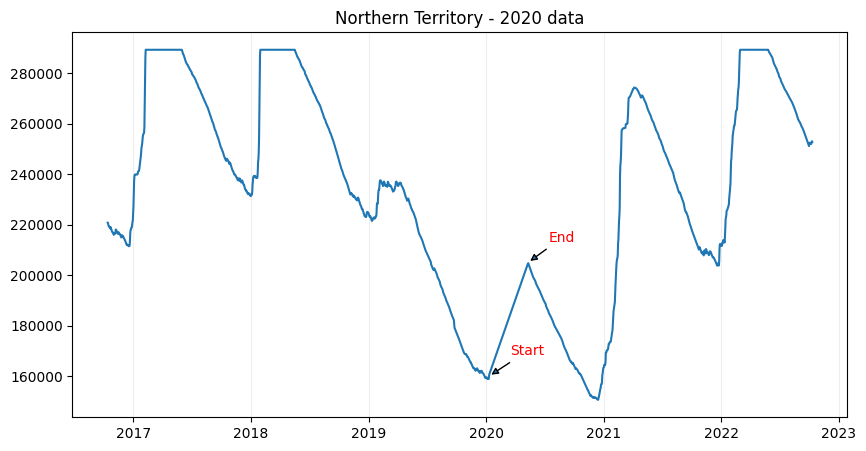

In [14]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
nt_data_2020 = nt_data[(nt_data['Reported date'] > '2020-01-01') & (nt_data['Reported date'] < '2020-12-31')]
nt_data_2020['Month'] = pd.DatetimeIndex(nt_data_2020['Reported date']).month
plt.figure(figsize=(10,5))

plt.plot(nt_data['Reported date'], nt_data['Available volume (ML)'])

x = dt.datetime(2020,1,10)
x2 = dt.datetime(2020,5,10)

plt.annotate('Start', xy=(mdates.date2num(x),160000),xytext=(15, 15), color='red', textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
plt.annotate('End', xy=(mdates.date2num(x2),205000),xytext=(15, 15), color='red', textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
plt.grid(axis='x', color='#eeeeee')
plt.title('Northern Territory - 2020 data')

Since the upward line of data should be a consistant number, I want to identify what the number is that the data is incrementing by. I will first get a new column which states the difference between iteself and its previous value

In [15]:
nt_data_2020['diff'] = nt_data_2020['Available volume (ML)'].diff()
nt_data_2020

C:\Users\vidmy2k\AppData\Local\Temp\ipykernel_13888\1356292769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nt_data_2020['diff'] = nt_data_2020['Available volume (ML)'].diff()


,State / Territory,Available volume (ML),Reported date,Month,diff
4574,Northern Territory,159488,2020-01-02,1,NaN
5942,Northern Territory,159282,2020-01-03,1,-206.0
5828,Northern Territory,159043,2020-01-04,1,-239.0
4831,Northern Territory,159015,2020-01-05,1,-28.0
5939,Northern Territory,159370,2020-01-06,1,355.0
...,...,...,...,...,...
5631,Northern Territory,157642,2020-12-26,12,810.0
6135,Northern Territory,160459,2020-12-27,12,2817.0
5234,Northern Territory,161024,2020-12-28,12,565.0
6010,Northern Territory,162263,2020-12-29,12,1239.0


I want to get the most common difference values and their quantity to see the data directly

In [16]:
nt_diff_data = nt_data_2020.groupby(['diff','Month']).size().sort_values(ascending=False).groupby(level=0).tail().reset_index()[:10]
nt_diff_data.sort_values(['Month','diff'])

,diff,Month,0
7,365.0,1,8
4,366.0,1,12
6,365.0,2,10
0,366.0,2,19
3,365.0,3,12
1,366.0,3,19
5,365.0,4,11
2,366.0,4,19
9,365.0,5,4
8,366.0,5,6


I can see that a rise of both 366 and 365 (some kind of float rounding?) has occured. This actually happens in multiple months, not just in the straight rise I identified in the above chart. This points more towards a general filler value across the data set instead of filling one gap. It would either be the mean or the mode of the data that was chosen. I will check both.

In [17]:
nt_no_fill = nt_data_2020[(nt_data_2020['diff'] != 360.0) & (nt_data_2020['diff'] != 365.0)]
print("Mean: ", nt_no_fill['diff'].mean())
print("Mode: ", nt_no_fill['diff'].mode())

Mean:  -39.85220125786164
Mode:  0    366.0
Name: diff, dtype: float64


I've identified that the data owner may have used the mode to fill the gaps in the data set.

### Generally heaviest rainfall months per state

In [18]:
# Creating Month and Year columns
catchment_main['Month'] = pd.DatetimeIndex(catchment_main['Reported date']).month
catchment_main['Year'] = pd.DatetimeIndex(catchment_main['Reported date']).year
catchment_main.head()

,State / Territory,Available volume (ML),Reported date,Month,Year
7891,Queensland,7834870,2016-10-13,10,2016
12362,Tasmania,12331455,2016-10-13,10,2016
13969,Victoria,9716932,2016-10-13,10,2016
17090,Western Australia,6871431,2016-10-13,10,2016
5493,Northern Territory,220827,2016-10-13,10,2016


In [19]:
# separating vic data into a DF we can work with.
# Adding a diff column for daily difference in catchment levels (indicates railfall/water usage)
vic_data2 = catchment_main[catchment_main['State / Territory'] == 'Victoria']
vic_data2['diff'] = vic_data2['Available volume (ML)'].diff()
#vic_data2[vic_data2['diff'] > 0].groupby(['Month','Year']).max().sort_values(by=['Year','diff'], ascending=False)

C:\Users\vidmy2k\AppData\Local\Temp\ipykernel_13888\3752942642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vic_data2['diff'] = vic_data2['Available volume (ML)'].diff()


In [20]:
# Summing each months difference for only positive results (positive rainfall for the month) and sorting for the wetest months each year that had positive rain fall
vic_data_pivotted = vic_data2.pivot_table(index=['Year','Month'], values='diff', aggfunc='sum').sort_values(by=['Year','Month'], ascending=False).reset_index().loc[lambda x: x['diff'] > 0]
vic_data_pivotted.sort_values(['Year','diff'], ascending=False)

,Year,Month,diff
2,2022,8,943450.0
4,2022,6,456989.0
1,2022,9,434501.0
3,2022,7,132608.0
5,2022,5,34995.0
9,2022,1,13837.0
15,2021,7,1088681.0
14,2021,8,728453.0
16,2021,6,645134.0
13,2021,9,588797.0


In [21]:
# From these results, I want to drop the year to only get summed months rainfall to better ID the wetter months

vic_final = vic_data_pivotted[['Month','diff']].groupby('Month').sum()
vic_final.sort_values(by='diff', ascending=False).head(5)

,diff
Month,
8,4268891.0
7,2304324.0
6,1985148.0
9,1888756.0
10,1474524.0


We can say that on average across the 5/6 years of the data set, the 5 wettest months were August, July, June, Sept, October. These line up with it being in the winter months giving more rainfall than other months of the year.

In [22]:
# Looking at other states with similar code above but condensed down into just the result

nsw_data2 = catchment_main[catchment_main['State / Territory'] == 'New South Wales']
nsw_data2['diff'] = nsw_data2['Available volume (ML)'].diff()
nsw_data_pivotted = nsw_data2.pivot_table(index=['Year','Month'], values='diff', aggfunc='sum').sort_values(by=['Year','Month'], ascending=False).reset_index().loc[lambda x: x['diff'] > 0]
nsw_final = nsw_data_pivotted[['Month','diff']].groupby('Month').sum()
nsw_final.sort_values(by='diff', ascending=False).head(5)

C:\Users\vidmy2k\AppData\Local\Temp\ipykernel_13888\4124045353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_data2['diff'] = nsw_data2['Available volume (ML)'].diff()


,diff
Month,
8,4470730.0
7,2911635.0
10,1749683.0
6,1483667.0
9,1475181.0


In [23]:
wa_data2 = catchment_main[catchment_main['State / Territory'] == 'Western Australia']
wa_data2['diff'] = wa_data2['Available volume (ML)'].diff()
wa_data_pivotted = wa_data2.pivot_table(index=['Year','Month'], values='diff', aggfunc='sum').sort_values(by=['Year','Month'], ascending=False).reset_index().loc[lambda x: x['diff'] > 0]
wa_final = wa_data_pivotted[['Month','diff']].groupby('Month').sum()
wa_final.sort_values(by='diff', ascending=False).head(5)

C:\Users\vidmy2k\AppData\Local\Temp\ipykernel_13888\1153259177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wa_data2['diff'] = wa_data2['Available volume (ML)'].diff()


,diff
Month,
1,6603829.0
2,4081267.0
3,2880938.0
12,841569.0
8,108488.0


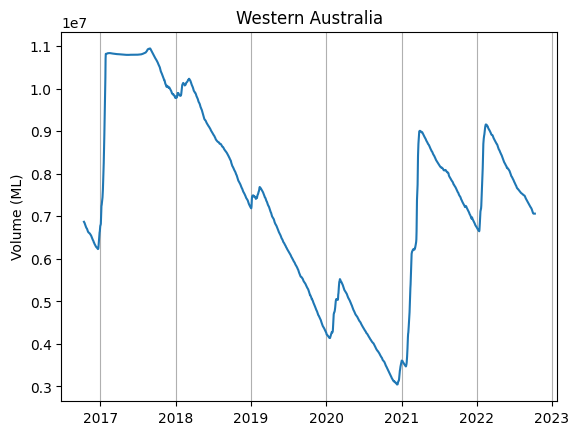

In [24]:
# Checking WA table above to their individual chart.
plt.plot(wa_data['Reported date'], wa_data['Available volume (ML)'])
plt.ylabel('Volume (ML)')
plt.title('Western Australia')
plt.grid(axis='x')


#### Identify
WA Catchment data looks a bit different to other states. From what I can see, their highest catchment amounts are in the first few months of the year, which is confirmed by the Water Corp website: https://www.watercorporation.com.au/Our-water/Rainfall-and-dams/Rainfall
I can only assume that even though rainfall isn't at its highest in the summer months, usage may be low to keep catchment levels at a higher level.

#### WA Catchment investigation
Checking on https://www.watercorporation.com.au/Our-water/Rainfall-and-dams/Dam-levels which shows dam levels throughout the state of WA. It shows that the southern part of WA where Perth is located has standard dry summers and wet winters with expected water usage, but in the north parts of WA has the opposite, they have wet summers and the capacity of dams are a lot larger than the southern dams, allowing for much more water storage. This loosely explains why the majority of WA's numbers show that summer has more rainfall (more capacity and rainfall in the north) and winter doesn't see capacity rise (as the north doesn't see much rain, but the majority of usage througout the year would be from the south of WA).

#### Rise in 2021 catchment levels
Another interesing point is the sudden rise in rainfall at the start of 2021. The information found regarding WA rainfall at this time from bom.gov.au:
"Perth Metro recorded a rainfall total of 892 mm in 2021, which was more than 150 mm above the annual average, and the second-highest annual rainfall on record, behind the record of 904.8 mm in 1995."
Record rainfall accounted for the sudden rise in catchment amounts. Another point to consider in the mix of record rainfall is the water useage restrictions in WA in the same period. From wa.gov.au website states:
"A winter sprinkler switch-off applies from 1 June to 31 August each year. From 1 September to 31 May, garden bore users can use sprinklers once a day, either before 9am or after 6pm, on their two rostered days each week"